In [ ]:
from googleapiclient.discovery import build
from dateutil import parser
import pandas as pd
from IPython.display import JSON

# Data viz packages
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
api_key = 'xxxxxx'

In [ ]:
channel_ids = ['UC2D2CMWXMOVWx7giW1n3LIg',
               # more channels here
              ]

In [ ]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(
    api_service_name, api_version, developerKey=api_key)


In [ ]:
def get_channel_stats(youtube, channel_ids):

    """
    Get channel stats

    Params:
    ------
    youtube: build object of Youtube API
    channel_ids: list of channel IDs

    Returns:
    ------
    dataframe with all channel stats for each channel ID

    """

    all_data = []

    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=','.join(channel_ids)
    )
    response = request.execute()

    # loop through items
    for item in response['items']:
        data = {'channelName': item['snippet']['title'],
                'subscribers': item['statistics']['subscriberCount'],
                'views': item['statistics']['viewCount'],
                'totalVideos': item['statistics']['videoCount'],
                'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
        }

        all_data.append(data)

    return pd.DataFrame(all_data)

def get_video_ids(youtube, playlist_id):

    video_ids = []

    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlist_id,
        maxResults = 50
    )
    response = request.execute()

    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])

    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
                    part='contentDetails',
                    playlistId = playlist_id,
                    maxResults = 50,
                    pageToken = next_page_token)
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')

    return video_ids


def get_video_details(youtube, video_ids):

    all_video_info = []

    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute()

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)

    return pd.DataFrame(all_video_info)

In [ ]:
channel_stats = get_channel_stats(youtube, channel_ids)

In [ ]:
channel_stats

,channelName,subscribers,views,totalVideos,playlistId
0,Andrew Huberman,4520000,210878231,188,UU2D2CMWXMOVWx7giW1n3LIg


In [ ]:
playlist_id = "UU2D2CMWXMOVWx7giW1n3LIg"

In [ ]:
# Get video IDs
video_ids = get_video_ids(youtube, playlist_id)

In [ ]:
len(video_ids)

188

In [ ]:
# Get video details
video_df = get_video_details(youtube, video_ids)
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,LRM5LutB538,Andrew Huberman,LIVE EVENT Q&A: Dr. Andrew Huberman Question &...,Recently I had the pleasure of hosting a live ...,"[andrew huberman, huberman lab podcast, huberm...",2023-12-13T13:00:25Z,50559,1767,None,139,PT54M44S,hd,true
1,ccrbE0QHy94,Andrew Huberman,Dr. Karen Parker: The Causes & Treatments for ...,"In this episode, my guest is Dr. Karen Parker,...","[andrew huberman, huberman lab podcast, huberm...",2023-12-11T13:00:24Z,150521,4088,None,1133,PT2H56M28S,hd,false
2,50BZQRT1dAg,Andrew Huberman,Robert Greene: A Process for Finding & Achievi...,"In this episode, my guest is Robert Greene, mu...","[andrew huberman, huberman lab podcast, huberm...",2023-12-04T13:00:07Z,953942,21841,None,1551,PT3H11M18S,hd,false
3,xTtM2AvCRyA,Andrew Huberman,"AMA #13: Winter Months & Sickness, Wim Hof Bre...",Welcome to a preview of the 13th Ask Me Anythi...,"[andrew huberman, huberman lab podcast, huberm...",2023-11-30T13:00:52Z,129392,3850,None,286,PT24M18S,hd,true
4,wG3UFHR1o48,Andrew Huberman,How to Stop Hiccups Using a Science-Supported ...,In this excerpt from the Huberman Lab episode ...,"[andrew huberman, huberman lab podcast, huberm...",2023-11-27T23:29:57Z,101835,7375,None,170,PT57S,hd,true
...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,NAATB55oxeQ,Andrew Huberman,"How to Defeat Jetlag, Shift Work & Sleeplessness","In this episode, I discuss a simple and reliab...","[sleep, andrew huberman, huberman lab, dr. and...",2021-01-25T13:00:18Z,448558,12359,None,1424,PT1H50M56S,hd,true
184,nwSkFq4tyC0,Andrew Huberman,"Using Science to Optimize Sleep, Learning & Me...","“Office Hours” — In this episode, I answer you...","[andrew huberman, dr. andrew huberman, sleep, ...",2021-01-18T13:00:25Z,1230602,35037,None,1982,PT1H41M26S,hd,true
185,nm1TxQj9IsQ,Andrew Huberman,Master Your Sleep & Be More Alert When Awake,Today's episode provides a host of information...,"[sleep, andrew huberman, dr. andrew huberman, ...",2021-01-11T13:59:33Z,3276233,96264,None,4895,PT1H22M5S,hd,true
186,H-XfCl-HpRM,Andrew Huberman,How Your Nervous System Works & Changes,Today’s episode provides an introduction to ho...,"[learning, learn faster, brain, understand you...",2021-01-04T16:00:44Z,1240168,52397,None,3013,PT1H2M31S,hd,true


## Data pre-processing

In [ ]:
# Check for NULL values
video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags              False
publishedAt       False
viewCount         False
likeCount         False
favouriteCount     True
commentCount      False
duration          False
definition        False
caption           False
dtype: bool

In [ ]:
# Check data types
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [ ]:
# Convert count columns to numeric
numeric_cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

In [ ]:
# Publish day in the week
video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(x))
video_df['pushblishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A"))

In [ ]:
!pip install isodate


In [ ]:
# convert duration to seconds
import isodate
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [ ]:
video_df[['durationSecs', 'duration']]

,durationSecs,duration
0,3284.0,PT54M44S
1,10588.0,PT2H56M28S
2,11478.0,PT3H11M18S
3,1458.0,PT24M18S
4,57.0,PT57S
...,...,...
183,6656.0,PT1H50M56S
184,6086.0,PT1H41M26S
185,4925.0,PT1H22M5S
186,3751.0,PT1H2M31S


In [ ]:
# Add tag count
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [ ]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,pushblishDayName,durationSecs,tagCount
0,LRM5LutB538,Andrew Huberman,LIVE EVENT Q&A: Dr. Andrew Huberman Question &...,Recently I had the pleasure of hosting a live ...,"[andrew huberman, huberman lab podcast, huberm...",2023-12-13 13:00:25+00:00,50559.0,1767.0,NaN,139.0,PT54M44S,hd,true,Wednesday,3284.0,9
1,ccrbE0QHy94,Andrew Huberman,Dr. Karen Parker: The Causes & Treatments for ...,"In this episode, my guest is Dr. Karen Parker,...","[andrew huberman, huberman lab podcast, huberm...",2023-12-11 13:00:24+00:00,150521.0,4088.0,NaN,1133.0,PT2H56M28S,hd,false,Monday,10588.0,10
2,50BZQRT1dAg,Andrew Huberman,Robert Greene: A Process for Finding & Achievi...,"In this episode, my guest is Robert Greene, mu...","[andrew huberman, huberman lab podcast, huberm...",2023-12-04 13:00:07+00:00,953942.0,21841.0,NaN,1551.0,PT3H11M18S,hd,false,Monday,11478.0,26
3,xTtM2AvCRyA,Andrew Huberman,"AMA #13: Winter Months & Sickness, Wim Hof Bre...",Welcome to a preview of the 13th Ask Me Anythi...,"[andrew huberman, huberman lab podcast, huberm...",2023-11-30 13:00:52+00:00,129392.0,3850.0,NaN,286.0,PT24M18S,hd,true,Thursday,1458.0,9
4,wG3UFHR1o48,Andrew Huberman,How to Stop Hiccups Using a Science-Supported ...,In this excerpt from the Huberman Lab episode ...,"[andrew huberman, huberman lab podcast, huberm...",2023-11-27 23:29:57+00:00,101835.0,7375.0,NaN,170.0,PT57S,hd,true,Monday,57.0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,NAATB55oxeQ,Andrew Huberman,"How to Defeat Jetlag, Shift Work & Sleeplessness","In this episode, I discuss a simple and reliab...","[sleep, andrew huberman, huberman lab, dr. and...",2021-01-25 13:00:18+00:00,448558.0,12359.0,NaN,1424.0,PT1H50M56S,hd,true,Monday,6656.0,15
184,nwSkFq4tyC0,Andrew Huberman,"Using Science to Optimize Sleep, Learning & Me...","“Office Hours” — In this episode, I answer you...","[andrew huberman, dr. andrew huberman, sleep, ...",2021-01-18 13:00:25+00:00,1230602.0,35037.0,NaN,1982.0,PT1H41M26S,hd,true,Monday,6086.0,14
185,nm1TxQj9IsQ,Andrew Huberman,Master Your Sleep & Be More Alert When Awake,Today's episode provides a host of information...,"[sleep, andrew huberman, dr. andrew huberman, ...",2021-01-11 13:59:33+00:00,3276233.0,96264.0,NaN,4895.0,PT1H22M5S,hd,true,Monday,4925.0,9
186,H-XfCl-HpRM,Andrew Huberman,How Your Nervous System Works & Changes,Today’s episode provides an introduction to ho...,"[learning, learn faster, brain, understand you...",2021-01-04 16:00:44+00:00,1240168.0,52397.0,NaN,3013.0,PT1H2M31S,hd,true,Monday,3751.0,12


In [ ]:
video_df['description']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0      Recently I had the pleasure of hosting a live ...
1      In this episode, my guest is Dr. Karen Parker,...
2      In this episode, my guest is Robert Greene, mu...
3      Welcome to a preview of the 13th Ask Me Anythi...
4      In this excerpt from the Huberman Lab episode ...
                             ...                        
183    In this episode, I discuss a simple and reliab...
184    “Office Hours” — In this episode, I answer you...
185    Today's episode provides a host of information...
186    Today’s episode provides an introduction to ho...
187    Welcome to the Huberman Lab podcast. I am Dr. ...
Name: description, Length: 188, dtype: object

In [ ]:
# Iterate through the DataFrame and print video ID, title, and a snippet of the description
for index, row in video_df.iterrows():
    video_id = row['video_id']
    title = row['title']
    description_snippet = ' '.join(row['description'].split()[:20])  # Adjust the number of words as needed

    print(f"Video ID: {video_id}, Title: {title}")
    print(f"Description Snippet: {description_snippet}...")
    print("\n")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Video ID: LRM5LutB538, Title: LIVE EVENT Q&A: Dr. Andrew Huberman Question & Answer in Chicago, IL
Description Snippet: Recently I had the pleasure of hosting a live event in Chicago, IL. This event was part of a lecture...


Video ID: ccrbE0QHy94, Title: Dr. Karen Parker: The Causes & Treatments for Autism
Description Snippet: In this episode, my guest is Dr. Karen Parker, Ph.D., professor of psychiatry and director of the Social Neurosciences Research...


Video ID: 50BZQRT1dAg, Title: Robert Greene: A Process for Finding & Achieving Your Unique Purpose
Description Snippet: In this episode, my guest is Robert Greene, multiple New York Times bestselling author and expert on human psychology and...


Video ID: xTtM2AvCRyA, Title: AMA #13: Winter Months & Sickness, Wim Hof Breathing & Stressors
Description Snippet: Welcome to a preview of the 13th Ask Me Anything (AMA) episode, part of Huberman Lab Premium. Huberman Lab Premium...


Video ID: wG3UFHR1o48, Title: How to Stop Hiccups Usin

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Extend the stopwords list with non-informative words
additional_stopwords = {'https', 'podcast', 'hubermanlab', 'please', 'support'}  # Add more as needed

# Function to extract key phrases
def extract_key_phrases(text, num_phrases=5):
    # Tokenize and filter stopwords
    stop_words = set(stopwords.words('english')).union(additional_stopwords)
    tokens = word_tokenize(text.lower())
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]

    # Count word frequency
    word_freq = Counter(filtered_tokens)

    # Return most common phrases
    return word_freq.most_common(num_phrases)

# Iterate through the DataFrame and print video title with its key phrases
for index, row in video_df.iterrows():
    video_title = row['title']
    description = row['description']

    key_phrases = extract_key_phrases(description)

    print(f"Title: {video_title}")
    print(f"Key Phrases: {key_phrases}")
    print("\n")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Title: LIVE EVENT Q&A: Dr. Andrew Huberman Question & Answer in Chicago, IL
Key Phrases: [('event', 5), ('chicago', 3), ('february', 3), ('hosting', 2), ('live', 2)]


Title: Dr. Karen Parker: The Causes & Treatments for Autism
Key Phrases: [('autism', 27), ('social', 20), ('vasopressin', 11), ('oxytocin', 9), ('children', 8)]


Title: Robert Greene: A Process for Finding & Achieving Your Unique Purpose
Key Phrases: [('relationships', 7), ('robert', 5), ('purpose', 5), ('experiences', 4), ('social', 4)]


Title: AMA #13: Winter Months & Sickness, Wim Hof Breathing & Stressors
Key Phrases: [('huberman', 8), ('lab', 7), ('premium', 6), ('ama', 5), ('episode', 4)]


Title: How to Stop Hiccups Using a Science-Supported Tool
Key Phrases: [('medical', 4), ('health', 3), ('hiccups', 3), ('advice', 3), ('huberman', 2)]


Title: Dr. Adam Grant: How to Unlock Your Potential, Motivation & Unique Abilities
Key Phrases: [('tool', 10), ('motivation', 6), ('potential', 5), ('tools', 5), ('procrastina

## EDA

### Best performing videos

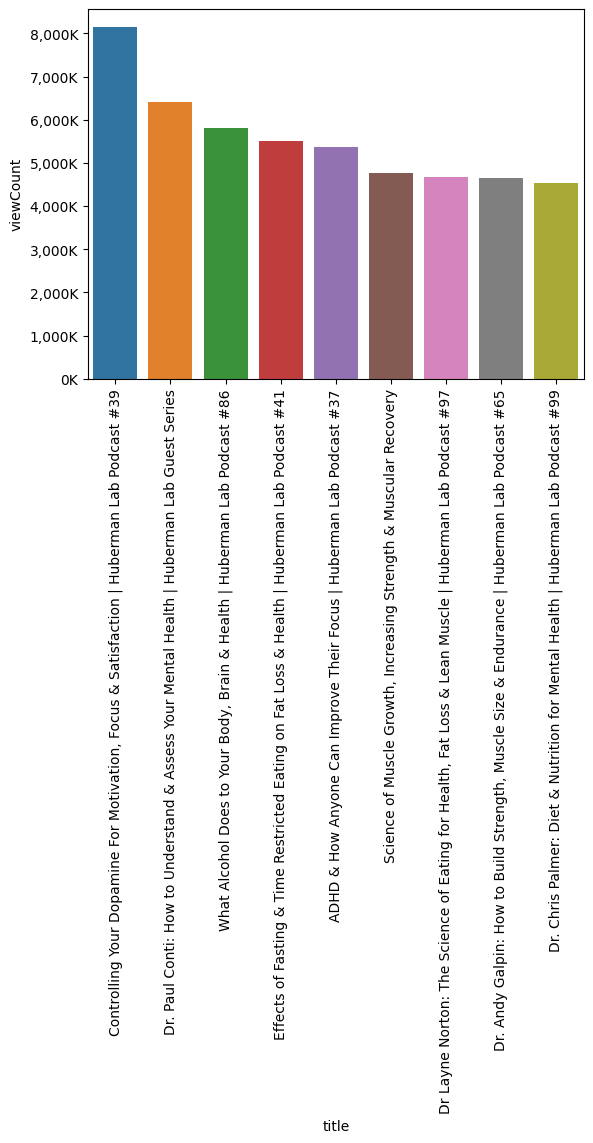

In [ ]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=False)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

### Worst performing videos

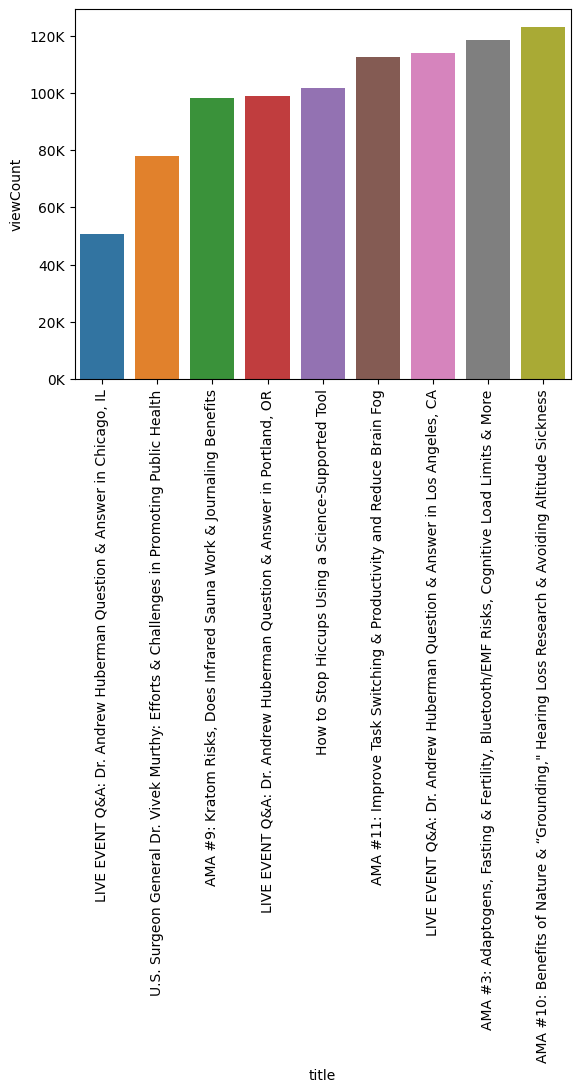

In [ ]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=True)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

### View distribution per video

<Axes: xlabel='channelTitle', ylabel='viewCount'>

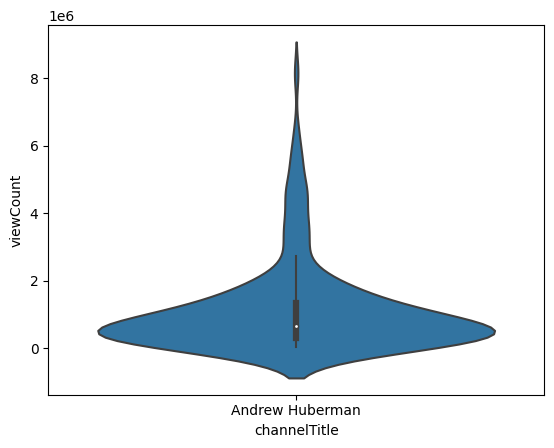

In [ ]:
sns.violinplot(x='channelTitle', y='viewCount', data=video_df)

### Views vs. likes and comments

<Axes: xlabel='likeCount', ylabel='viewCount'>

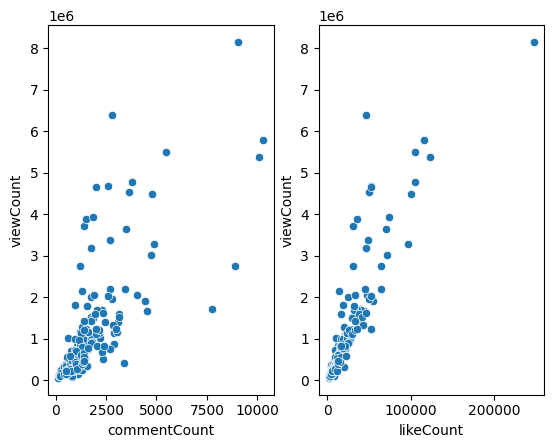

In [ ]:
fig, ax = plt.subplots(1,2)
sns.scatterplot(data = video_df, x = 'commentCount', y = 'viewCount', ax = ax[0])
sns.scatterplot(data = video_df, x = 'likeCount', y = 'viewCount', ax = ax[1])

### Video duration

<Axes: xlabel='durationSecs', ylabel='Count'>

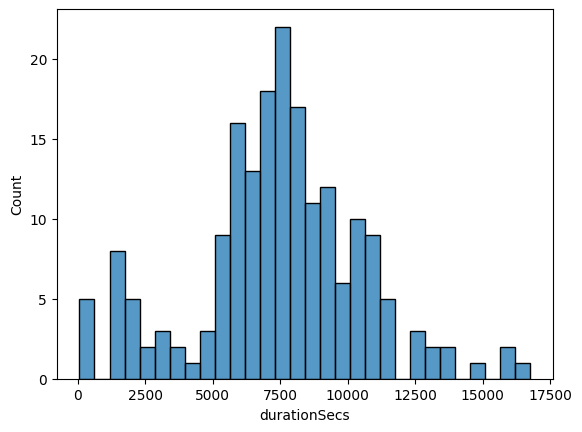

In [ ]:
sns.histplot(data = video_df, x = 'durationSecs', bins=30)

### Wordcloud for video titles

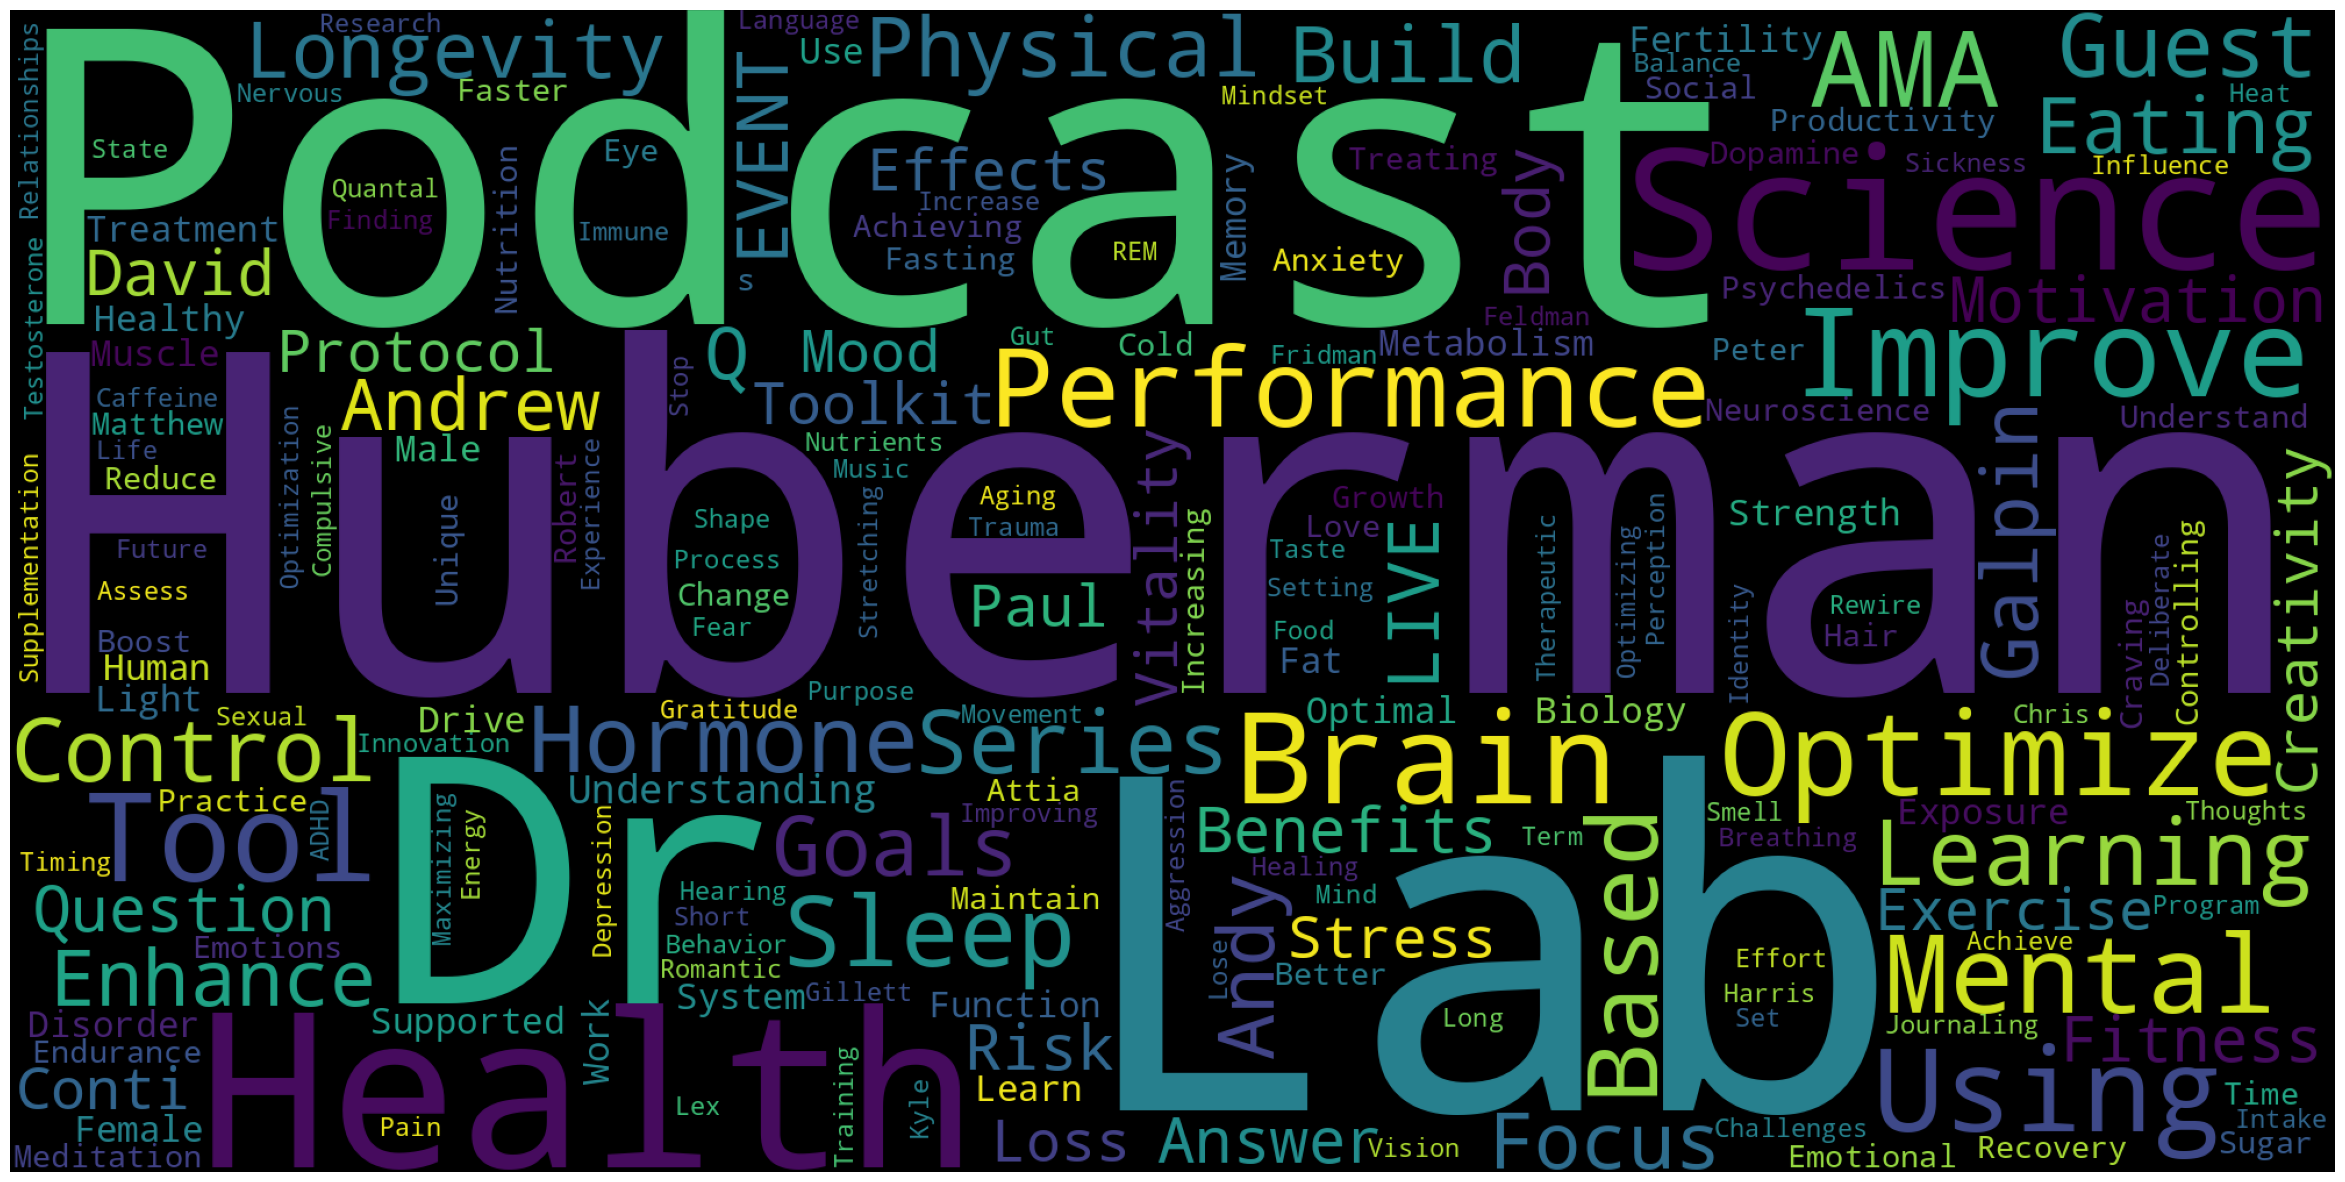

In [ ]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words)

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud)
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black',
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

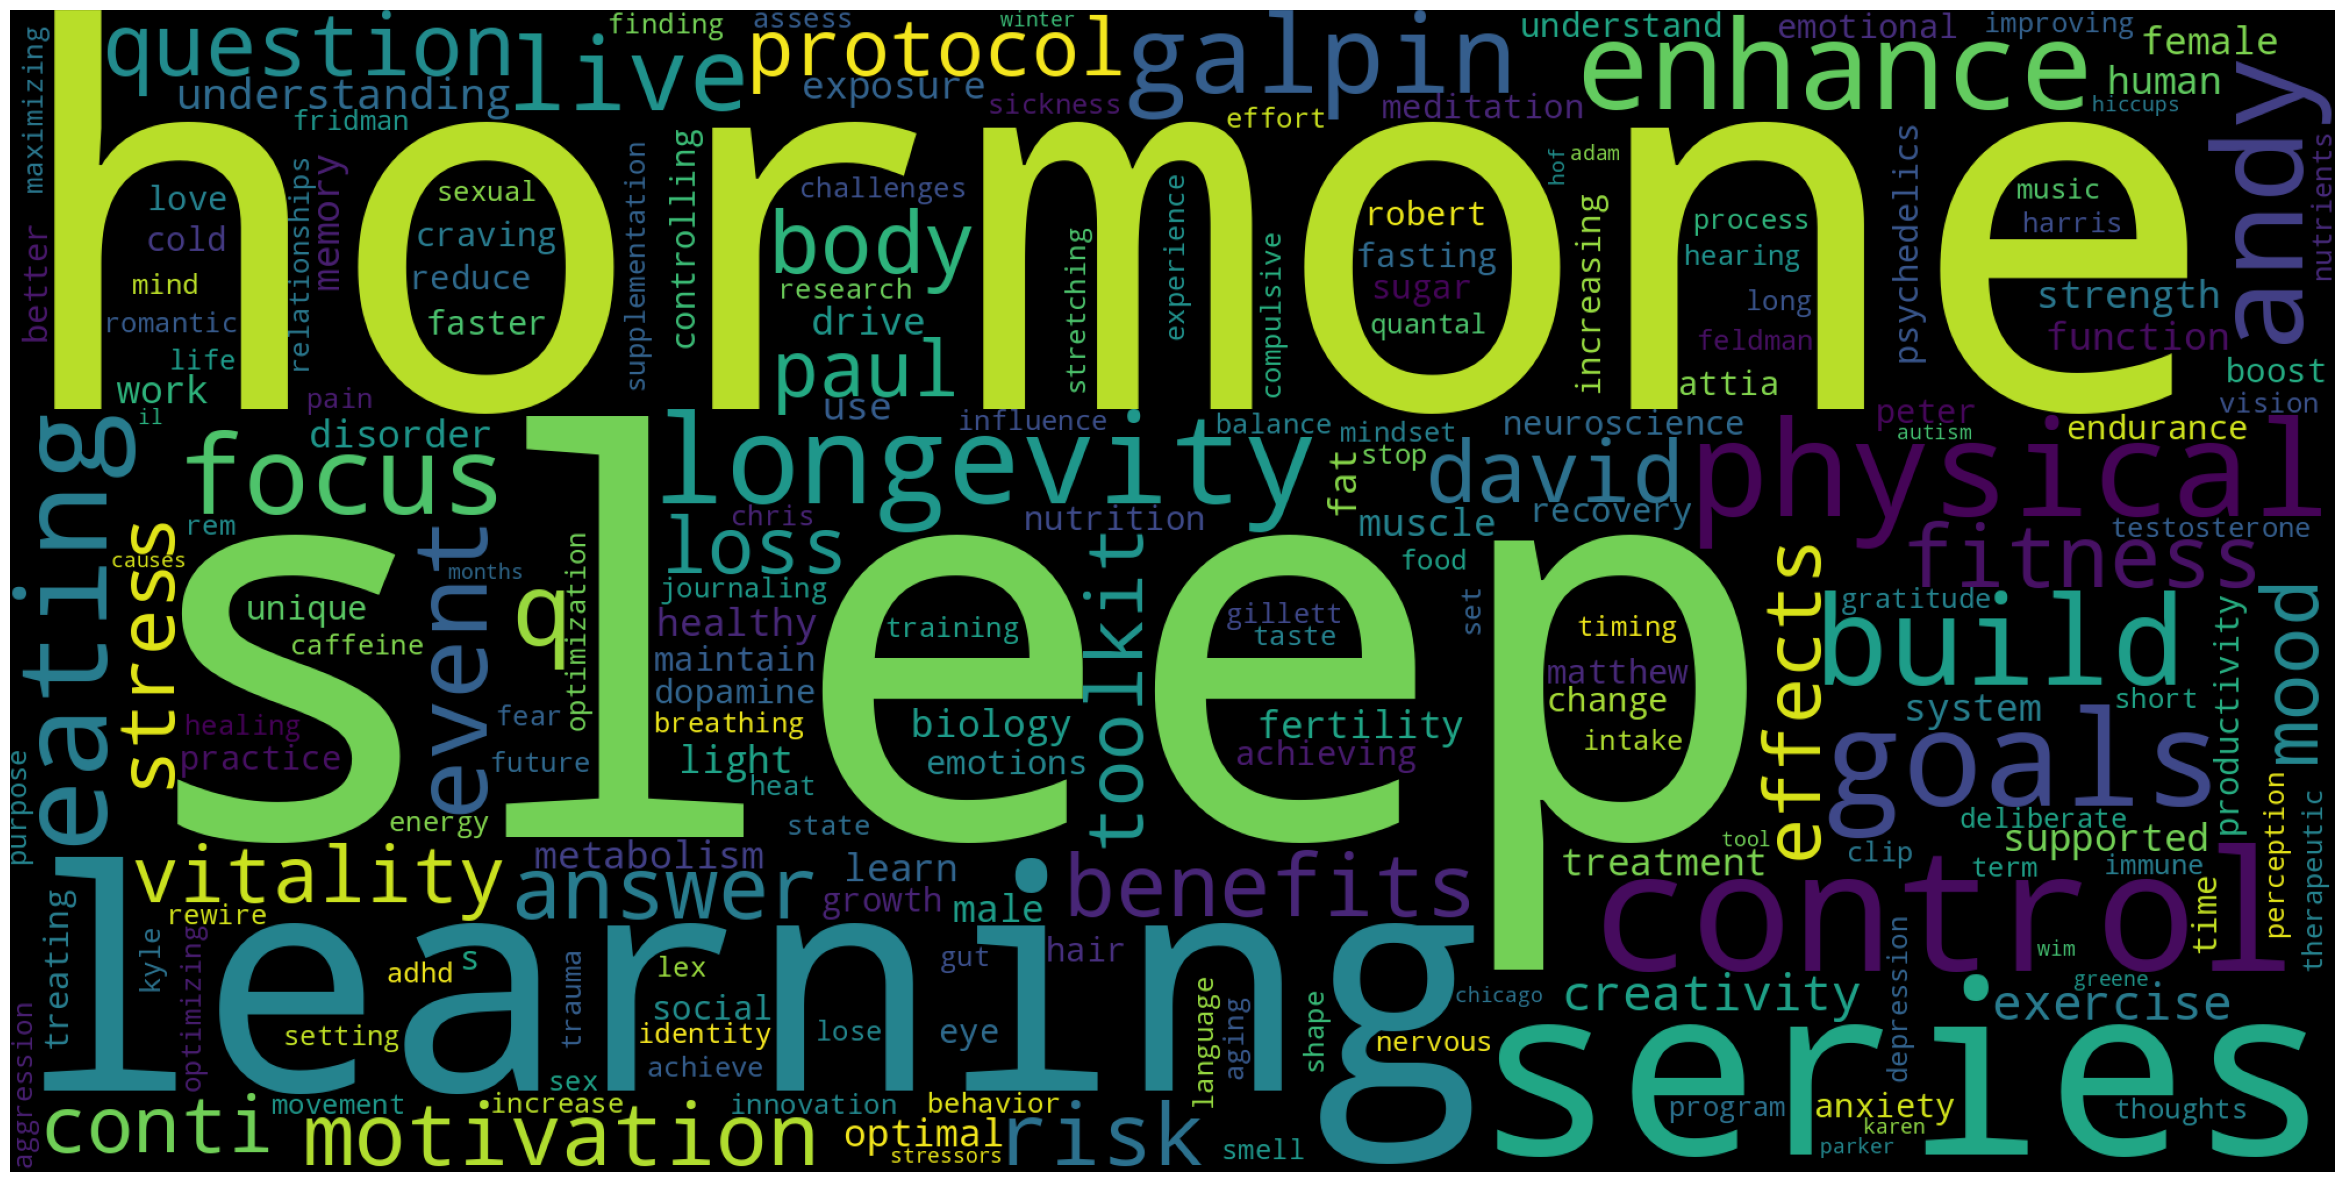

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Extend the default stopwords list with your specific words
# Convert all custom stopwords to lowercase
custom_stopwords = set([word.lower() for word in ['guest','based','science', 'ama', 'performance', 'mental', 'improve', 'optimize',
                                                  'using', 'health', 'tools', 'brain', 'dr', 'lab', 'andrew',
                                                  'podcast', 'huberman']])  # Note: 'Dr.', 'Science' are in lowercase
stop_words = set(STOPWORDS).union(custom_stopwords)

# Function to process titles and remove stop words
def process_title(title):
    # Convert to lowercase and split into words
    words = title.lower().split()
    # Remove stopwords and punctuation
    return ' '.join(word.strip('.,!?:;') for word in words if word not in stop_words)

# Apply the function to each title
video_df['title_no_stopwords'] = video_df['title'].apply(process_title)

# Join all words into a single string
all_words_str = ' '.join(video_df['title_no_stopwords'])

# Function to plot the word cloud
def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud)
    plt.axis("off")

# Generate and plot word cloud
wordcloud = WordCloud(width=2000, height=1000, random_state=1, background_color='black',
                      colormap='viridis', collocations=False, stopwords=stop_words).generate(all_words_str)
plot_cloud(wordcloud)


In [ ]:
import spacy
from collections import Counter
import re

# Load the small English model
nlp = spacy.load('en_core_web_sm')

# Define your custom stopwords (non-informative words)
custom_stopwords = {'series','health', 'science','ama','dr', 'lab', 'andrew', 'podcast', 'huberman', 'dr.',
                    'to', 'how', 'your', 'of', 'for', 'the',
                    'using', 'in', 'a', 'and', 'with'}

# Function to extract nouns from text
def extract_nouns(text):
    doc = nlp(text.lower())
    # Filter out non-alphabetic tokens and stopwords
    nouns = [token.text for token in doc if token.pos_ == 'NOUN'
             and token.text.isalpha() and token.text not in custom_stopwords]
    return nouns

# Apply the function to each title and flatten the list of words
all_nouns = [noun for title in video_df['title'] for noun in extract_nouns(title)]

# Count the frequency of each noun
noun_freq = Counter(all_nouns)

# Sort by frequency (high to low) and get top 20 nouns
top_nouns = noun_freq.most_common(50)

# Display the top nouns and their frequencies
for noun, freq in top_nouns:
    print(f"{noun}: {freq}")


tools: 17
brain: 16
performance: 13
sleep: 11
goals: 8
event: 6
question: 6
answer: 6
motivation: 6
benefits: 6
toolkit: 5
effects: 5
risks: 5
stress: 5
body: 5
understanding: 5
hormone: 4
fertility: 4
vitality: 4
function: 4
longevity: 4
memory: 4
mood: 4
loss: 4
fitness: 4
exposure: 4
hormones: 4
metabolism: 4
learning: 4
strength: 4
creativity: 4
biology: 4
focus: 4
light: 4
system: 4
emotions: 3
productivity: 3
protocols: 3
neuroscience: 3
males: 3
drive: 3
growth: 3
eye: 3
psychedelics: 3
hair: 3
eating: 3
dopamine: 3
fasting: 3
anxiety: 3
nutrition: 3


Dopamine: 2
Serotonin: 1
Neuroscience: 3
Brain: 13
Neuron: 0


### Upload schedule

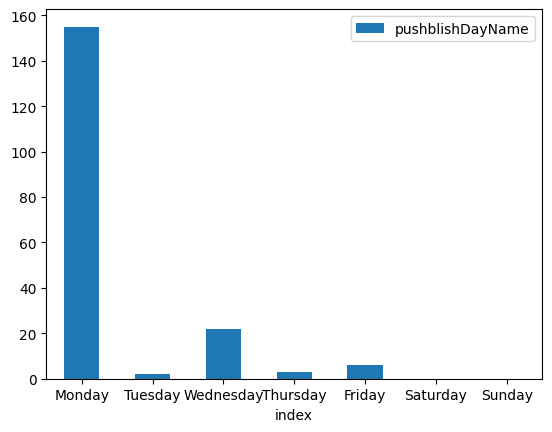

In [ ]:
day_df = pd.DataFrame(video_df['pushblishDayName'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.reset_index().plot.bar(x='index', y='pushblishDayName', rot=0)